In [71]:
%matplotlib inline
import pandas as pd
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fp = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/'

In [3]:
case_to_article_links = pd.read_csv(os.path.join(fp, 'case-to-article-links.csv'))

In [4]:
case_to_article_links.shape

(1828757, 4)

In [16]:
case_to_article_links.head()

,link_id,source,target,linktype
0,http://localhost:8984/bigdata/namespace/Regell...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,http://linkeddata.overheid.nl/terms/linktype/i...
1,http://localhost:8984/bigdata/namespace/Regell...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,http://linkeddata.overheid.nl/terms/linktype/i...
2,http://localhost:8984/bigdata/namespace/Regell...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,http://linkeddata.overheid.nl/terms/linktype/i...
3,http://localhost:8984/bigdata/namespace/Regell...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,http://linkeddata.overheid.nl/terms/linktype/i...
4,http://localhost:8984/bigdata/namespace/Regell...,http://linkeddata.overheid.nl/terms/jurisprude...,http://linkeddata.overheid.nl/terms/bwb/id/BWB...,http://linkeddata.overheid.nl/terms/linktype/i...


In [30]:
case_to_article_links.groupby('linktype').count()

,link_id,source,target
linktype,,,
http://linkeddata.overheid.nl/terms/linktype/id/hudoc-referentie,119771,119771,119771
http://linkeddata.overheid.nl/terms/linktype/id/lx-referentie,1539556,1539556,1539556
http://linkeddata.overheid.nl/terms/linktype/id/rvr-referentie,169430,169430,169430


In [19]:
# Select only one entry for each source,target combination
case_to_article_links_distinct = case_to_article_links.groupby(['source', 'target']).nunique()['source']

In [39]:
# Store the order of the identifiers
case_ids = case_to_article_links_distinct.index.levels[0]
article_ids = case_to_article_links_distinct.index.levels[1]

In [40]:
len(case_ids), len(article_ids)

(419329, 58800)

In [24]:
# put edgelist in sparse matrix format
mat_sparse = scipy.sparse.coo_matrix(
                (case_to_article_links_distinct.values, 
                 (case_to_article_links_distinct.index.labels[0], case_to_article_links_distinct.index.labels[1])))

In [25]:
mat_sparse

<419329x58800 sparse matrix of type '<class 'numpy.int64'>'
	with 1750407 stored elements in COOrdinate format>

In [32]:
# the cocitation matrix is simply the dot product
mat_cocitation = mat_sparse.T.dot(mat_sparse)

In [56]:
mat_cocitation

<58800x58800 sparse matrix of type '<class 'numpy.int64'>'
	with 3243410 stored elements in Compressed Sparse Row format>

In [52]:
# retrieve indices of non-zero entries
x_index, y_index, data = scipy.sparse.find(mat_cocitation)

In [54]:
df_cocitation = pd.DataFrame({'source':article_ids[x_index],
             'target': article_ids[y_index],
             'weight': data})

In [58]:
# Drop self-loops and duplicates
df_cocitation = df_cocitation[df_cocitation['source']<df_cocitation['target']]

In [61]:
df_cocitation.index.name = 'id'

In [62]:
df_cocitation.shape

(1592305, 3)

In [92]:
# Write to database
import sqlalchemy
engine = sqlalchemy.create_engine('mysql+pymysql://dafne@localhost/caselaw?charset=utf8')
df_cocitation.to_sql('links_article_to_article', engine)

In [63]:
df_cocitation.to_csv(os.path.join(fp, 'article_to_article.csv'))

In [75]:
df_cocitation.weight.max()

7582

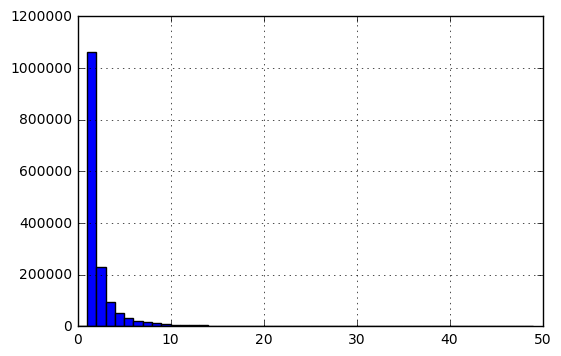

In [68]:
# Look at the weight distribution
df_cocitation['weight'].hist(bins=range(50));

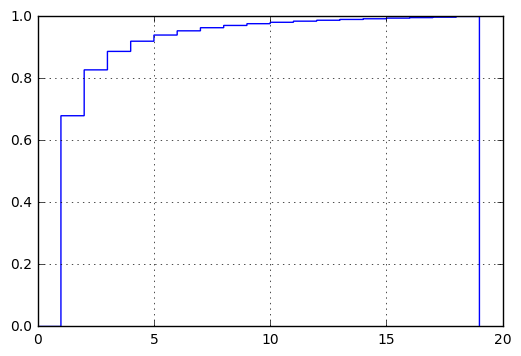

In [74]:
# What part of the netwerk remains if we cutoff beyond a certain weight value?
df_cocitation['weight'].hist(bins=range(20), cumulative=True, histtype='step', normed=1);

In [78]:
len(set(df_cocitation['source'].unique()).union(set(df_cocitation['target'].unique())))

58214

In [87]:
# How large is the network (weights and edges) for each cut-off value?
w_max = 20

n = np.zeros(w_max)
m = np.zeros(w_max)

for i in range(w_max):
    df_sub =  df_cocitation[df_cocitation['weight']>=i+1]
    n[i] = len(set(df_sub['source'].unique()).union(set(df_sub['target'].unique())))
    m[i] = len(df_sub)

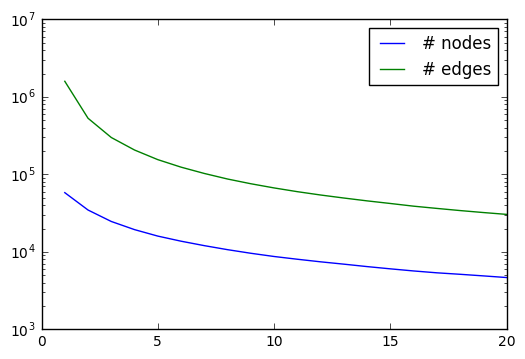

In [88]:
plt.plot(np.arange(1, w_max+1), n, label='# nodes')
plt.plot(np.arange(1, w_max+1), m, label='# edges')
plt.legend()
plt.yscale('log')
plt.show()

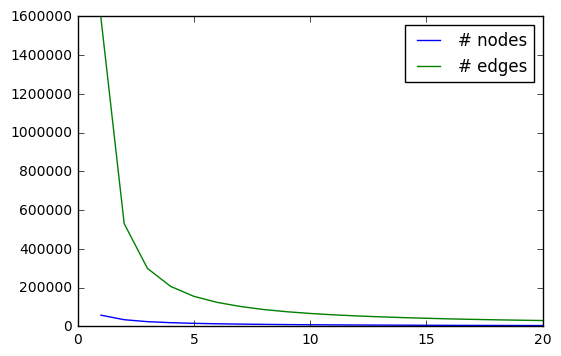

In [89]:
plt.plot(np.arange(1, w_max+1), n, label='# nodes')
plt.plot(np.arange(1, w_max+1), m, label='# edges')
plt.legend()
plt.show()

In [90]:
df_min5 =  df_cocitation[df_cocitation['weight']>=5]

In [93]:
df_min5.to_csv(os.path.join(fp, 'article_to_article_min5.csv'))

In [99]:
df_min5.groupby(['source', 'target']).count().sort_values('weight', ascending=False)

weight
source                                             target                                                    
http://linkeddata.overheid.nl/terms/bwb/id/BWBR... http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
http://linkeddata.overheid.nl/terms/bwb/id/BWBR... http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
http://linkeddata.overheid.nl/terms/bwb/id/BWBR... http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
http://linkeddata.overheid.nl/terms/bwb/id/BWBR... http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBV...       1
...                                                                                                       ...
http://linkeddata.overheid.nl/terms/bwb/id/BWBR... http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                                   http://linkeddata.overheid.nl/terms/bwb/id/BWBR...       1
                                 

In [100]:
print(n[4], m[4])

16016.0 155283.0


In [103]:
article_nodes = pd.read_csv(os.path.join(fp, 'article_nodes_nodup.csv'), encoding='utf-8')

In [149]:
article_nodes['book'] = article_nodes.title.str.split(',').map(lambda l: l[0])

In [105]:
node_ids = set(df_min5['source'].unique()).union(set(df_min5['target'].unique()))

In [124]:
nodes_min5 = article_nodes[article_nodes.id.isin(node_ids)].copy()
nodes_min5.shape

(16016, 4)

## Network statistics

In [113]:
import networkx as nx
import community

In [111]:
graph = nx.from_pandas_dataframe(df_min5, 'source', 'target', edge_attr=True)

In [ ]:
statistics = {
    'degree': graph.degree(),
    'degree_centrality': nx.degree_centrality(graph),
    'betweenness_centrality': nx.betweenness_centrality(graph),
    'closeness_centrality': nx.closeness_centrality(graph),
}

In [114]:
partition = community.best_partition(graph)

In [150]:
modularity = community.modularity(partition, graph)

In [126]:
nodes_min5['community'] = [str(partition[n_id]) for n_id in nodes_min5['id']]

In [136]:
c_tab = nodes_min5.groupby(['community', 'authority']).count()['id'].unstack().fillna(0)
c_tab

authority,Algemene Zaken,Autoriteit Financiële Markten,Bedrijfschap Afbouw,Binnenlandse Zaken en Koninkrijksrelaties,Buitenlandse Zaken,Defensie,Economische Zaken,Faunafonds,Financiën,Fonds Podiumkunsten,...,Koninklijke Notariële Beroepsorganisatie,Nederlandse Orde van Accountants-Administratieconsulenten,"Onderwijs, Cultuur en Wetenschap",Productschap Vee en Vlees,Raad voor Rechtsbijstand,Sociale Verzekeringsbank,Sociale Zaken en Werkgelegenheid,Uitvoeringsinstituut werknemersverzekeringen,Veiligheid en Justitie,"Volksgezondheid, Welzijn en Sport"
community,,,,,,,,,,,,,,,,,,,,,
0,13.0,0.0,0.0,97.0,194.0,2.0,36.0,0.0,165.0,0.0,...,0.0,0.0,7.0,0.0,0.0,0.0,139.0,0.0,1331.0,148.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
10,0.0,0.0,0.0,13.0,5.0,1.0,94.0,0.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,931.0,85.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
101,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
105,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0


In [147]:
nodes_min5.to_csv(os.path.join(fp, 'article_nodes_nodup_min5.csv'), index=False)